In [1]:
import arviz as az
import numpy as np
import pickle as pkl

In [2]:
import pymc as pm
from haplm.gp_util import GP, SphereGneiting

In [3]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [4]:
from matplotlib import rc, rcParams
rc('font', **{'family': 'serif', 'serif': ['Palatino']})
rc('text', usetex = True) # uncomment if no LaTeX setup
rc('font', size=14)

# colors for plotting
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854']

In [5]:
from PIL import Image

pfpr_dict = {}
for yr in range(2000, 2021):
    im = Image.open(f'../../data/dhps/Africa_pfpr_{yr}.tif') 
    pfpr = np.asarray(im)
    pfpr_masked = np.ma.masked_less(pfpr, 0)
    pfpr_dict[yr] =  pfpr_masked
    
# number of pixels to predict on per year
mask = pfpr_masked.mask
N_pred = mask.size - mask.sum()

RAD_TO_DEG = 180/np.pi
topleft = np.array([im.tag[33922][3], im.tag[33922][4]]) * RAD_TO_DEG
step = np.array([im.tag[33550][0], -im.tag[33550][1]]) * RAD_TO_DEG
# coordinates for points of prediction
yidxs, xidxs = np.where(np.logical_not(mask))
points = topleft + np.array([xidxs, yidxs]).T*step

In [6]:
def create_masked(val_arr, mask, fill=None):
    if fill is None:
        vals = [[0 for _ in row] for row in mask]
    else:
        vals = [[fill for _ in row] for row in mask]
    idx = 0
    for i, row in enumerate(mask):
        for j, masked in enumerate(row):
            if not masked:
                vals[i][j] = val_arr[idx]
                idx += 1
    return np.ma.masked_array(vals, mask) if fill is None else np.array(vals)

In [7]:
Xnew = np.c_[points, yr*np.ones(N_pred), pfpr_masked.compressed()]
Xnew.shape

(35602, 4)

In [8]:
with open('../../test/dhps/data.pkl', 'rb') as fp:
    data = pkl.load(fp)
    ys = data['ys']
    ns = data['ns']
    amats = data['amats']
    infos = data['infos']
    X = data['X']
    lm_list = data['lm_list']
N = len(ys)
H = 8

## MCMC diagnostics

In [9]:
idata = az.from_netcdf('../../data/dhps/exact.netcdf')

In [10]:
rhat = az.rhat(idata)
for k, v in rhat.items():
    print(k, v.values.max())

f0_rotated_ 1.0080923162665407
f1_rotated_ 1.0099033582263754
f2_rotated_ 1.0152648537629025
f3_rotated_ 1.0105753215328257
f4_rotated_ 1.012484768061711
f5_rotated_ 1.0142171725444171
f6_rotated_ 1.0140795920511307
f7_rotated_ 1.0105967132773745
sigma 1.0038037332051843
alpha 1.014599539831844
ls_t 1.0118326854531168
ls_s 1.004573777884965
mu 1.003207038855781
beta 1.0036107414612963
f0 1.0066467232304197
f1 1.0062536233797916
f2 1.0058003714424923
f3 1.0071530407911744
f4 1.0095347054493575
f5 1.0081069942026428
f6 1.0073777797613015
f7 1.0073762122938579
p 1.0137193257186512


In [11]:
pess = az.ess(idata, var_names=['p'])['p'].values.flatten()

In [12]:
idata.sample_stats.attrs

{'arviz_version': '0.14.0',
 'created_at': '2023-05-03T23:17:33.116008',
 'mcmc_walltime': 37625.229295253754,
 'preprocess_time': 69.58714175224304}

In [13]:
(37625+70)/3600 # 10.5 hours wall time

10.470833333333333

In [14]:
# divergences
idata.sample_stats.diverging.values.sum()

0

In [15]:
args = pess.argsort()
# show min ESS, median ESS, max ESS
minarg, medarg, maxarg = args[0], args[len(args)//2], args[-1]
for arg in (minarg, medarg, maxarg):
    print(arg // 8, arg % 8, pess[arg].round())

114 4 523.0
238 3 2775.0
124 3 6328.0


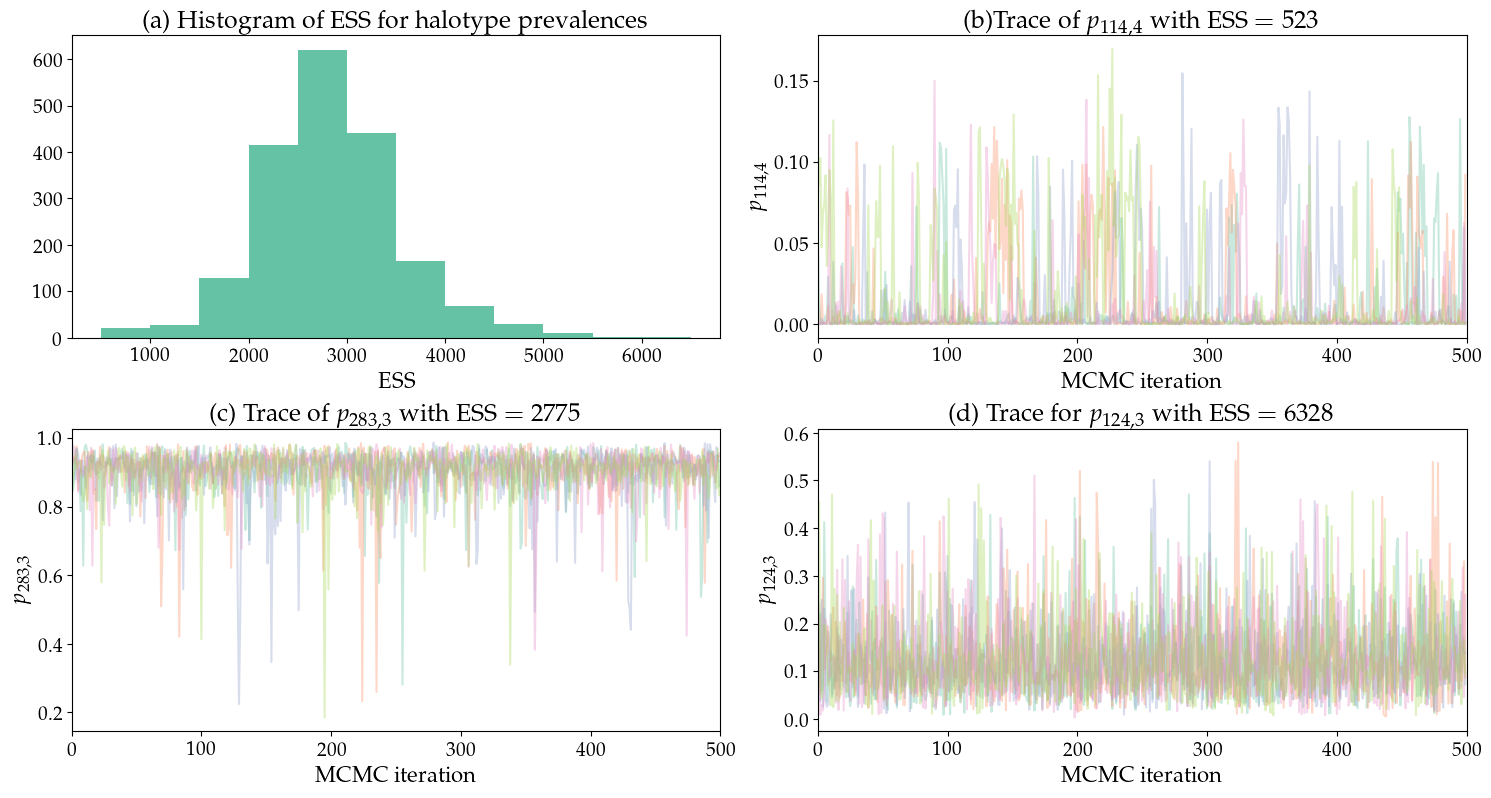

In [31]:
fig, axes = plt.subplots(figsize=(15, 8), ncols=2, nrows=2)

ax = axes[0,0]
ax.hist(pess, color=colors[0], bins=np.arange(500,6600,500));
ax.set_xlabel('ESS', fontsize=16)
ax.set_title('(a) Histogram of ESS for halotype prevalences', fontsize=18)

for i in range(3):
    ax = axes.flatten()[i+1]
    arg = (minarg, medarg, maxarg)[i]
    for c in range(5):
        ax.plot(idata.posterior.p[c,:,arg//8,arg%8].T, alpha=0.35, color=colors[c]);
    ax.set_xticks(np.arange(0,501,100))
    ax.set_xlim(0,500)
    ax.set_xlabel('MCMC iteration', fontsize=16)
    ax.set_ylabel(['$p_{114,4}$','$p_{283,3}$','$p_{124,3}$'][i], fontsize=16)
    ax.set_title(['(b)Trace of $p_{114,4}$ with ESS $=523$',
                  '(c) Trace of $p_{283,3}$ with ESS $=2775$',
                  '(d) Trace for $p_{124,3}$ with ESS $=6328$'][i], fontsize=18)
    
fig.subplots_adjust(top=0.95, bottom=0.08, left=0.05, right=0.98, wspace=0.15, hspace=0.3)
plt.savefig(f'ess_trace.png');  

In [17]:
az.summary(idata, var_names=['mu', 'beta', 'alpha', 'sigma', 'ls_s', 'ls_t'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],3.323,0.824,1.786,4.859,0.016,0.012,2535.0,1771.0,1.00
mu[1],3.500,0.702,2.194,4.830,0.015,0.011,2162.0,1742.0,1.00
mu[2],0.053,1.082,-1.917,2.098,0.023,0.021,2226.0,1855.0,1.00
mu[3],1.573,1.024,-0.299,3.569,0.021,0.015,2333.0,1761.0,1.00
mu[4],-2.414,0.924,-4.202,-0.709,0.020,0.014,2224.0,1999.0,1.00
mu[5],-1.950,1.176,-4.039,0.260,0.023,0.017,2681.0,1864.0,1.00
mu[6],-2.934,0.992,-4.893,-1.123,0.019,0.014,2803.0,2167.0,1.00
mu[7],-1.151,1.205,-3.538,0.926,0.025,0.019,2387.0,2085.0,1.00
beta[0],-0.018,0.812,-1.494,1.503,0.017,0.015,2408.0,1994.0,1.00
beta[1],0.039,0.790,-1.492,1.559,0.015,0.015,2631.0,1653.0,1.00


## Load summary statistics of posterior predictive

In [18]:
yrs = list(range(2000, 2021))
sumstats_dict = {}
for yr in yrs:
    with open(f'../../data/dhps/exact_{yr}_sumstats.pkl', 'rb') as fp:
        sumstats_dict[yr] = pkl.load(fp)

In [19]:
max_by_year = np.array([sumstats_dict[yr]['median'].max(axis=0) for yr in yrs])
mean_by_year = np.array([sumstats_dict[yr]['median'].mean(axis=0) for yr in yrs])
median_by_year = np.array([np.median(sumstats_dict[yr]['median'], axis=0) for yr in yrs])

In [20]:
q1_by_year = np.array([np.quantile(sumstats_dict[yr]['median'], 0.25, axis=0) for yr in yrs])
q3_by_year = np.array([np.quantile(sumstats_dict[yr]['median'], 0.75, axis=0) for yr in yrs])
# bot15_by_year = np.array([np.quantile(sumstats_dict[yr]['median'], 0.15, axis=0) for yr in yrs])
# top15_by_year = np.array([np.quantile(sumstats_dict[yr]['median'], 0.85, axis=0) for yr in yrs])
bot5_by_year = np.array([np.quantile(sumstats_dict[yr]['median'], 0.05, axis=0) for yr in yrs])
top5_by_year = np.array([np.quantile(sumstats_dict[yr]['median'], 0.95, axis=0) for yr in yrs])

In [21]:
max_sd = max(sumstats_dict[yr]['sd'].max() for yr in yrs)
max_sd

0.35013490579273504

In [22]:
max_sd = max(sumstats_dict[yr]['geno_sd'].max() for yr in yrs)
max_sd

0.34637830372311457

## Haplotype names

In [23]:
hap_names_dash = []
hap_names_uscore = []
for h in range(H):
    wt1 = '' if h & 1 else 'A'
    mt1 = 'G' if h & 1 else ''
    wt2 = '' if h & 2 else 'K'
    mt2 = 'E' if h & 2 else ''
    wt3 = '' if h & 4 else 'A'
    mt3 = 'G' if h & 4 else ''
    hap_names_dash.append('\\textit{dhps} ' + f'{wt1}437{mt1}-{wt2}540{mt2}-{wt3}581{mt3}')
    hap_names_uscore.append(f'{wt1}437{mt1}_{wt2}540{mt2}_{wt3}581{mt3}')
geno_names = ['\\textit{dhps} ' + name for name in hap_names_uscore[-1].split('_')]

## Export median rasters

In [24]:
del im.tag_v2[42112]

In [25]:
for h in range(8):
    for year in range(2000, 2021):
        vals = sumstats_dict[year]['median'][:,h]
        im.putdata(create_masked(vals, mask, pfpr.min()).flatten())        
        im.save(f'hap_maps/{hap_names_uscore[h]}/{year}_median.tif', tiffinfo=im.tag_v2)

## Plot trends

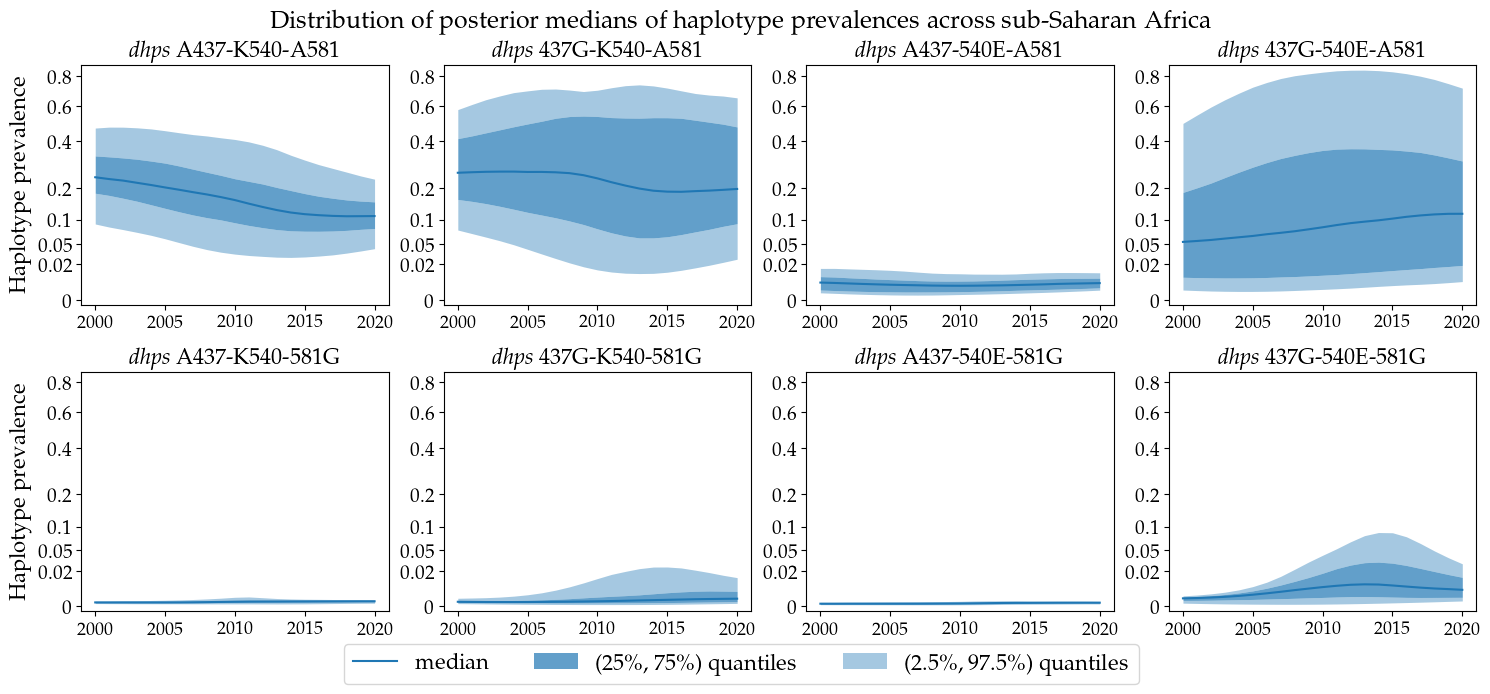

In [29]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15,7))
color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
transform = np.sqrt
for h in range(H):
    ax = axes[h//4][h%4]
    ax.plot(yrs, transform(median_by_year[:,h]), color=color, label='median')
    #ax.fill_between(yrs, bot5_by_year[:,h], bot15_by_year[:,h], alpha=0.2, color=color, linewidth=0)
    ax.fill_between(yrs, transform(bot5_by_year[:,h]), transform(q1_by_year[:,h]), alpha=0.4, color=color, linewidth=0)
    ax.fill_between(yrs, transform(q1_by_year[:,h]), transform(q3_by_year[:,h]), alpha=0.7, color=color, linewidth=0, label='(25\%, 75\%) quantiles')
    ax.fill_between(yrs, transform(q3_by_year[:,h]), transform(top5_by_year[:,h]), alpha=0.4, color=color, linewidth=0, label='(2.5\%, 97.5\%) quantiles')
    #ax.fill_between(yrs, top15_by_year[:,h], top5_by_year[:,h], alpha=0.2, color=color, linewidth=0)
    ax.set_ylim((-0.02, transform(top5_by_year.max())+0.02))
    #ax.set_xlim((2000, 2020))
    
    yticks = [0,0.02,0.05,0.1,0.2,0.4,0.6,0.8]
    if h % 4 == 0:
        ax.set_ylabel('Haplotype prevalence', fontsize=16)
        ax.set_yticks(transform(yticks), [round(x, 2) for x in yticks])
    else:
        ax.set_yticks(transform(yticks), [round(x, 2) for x in yticks])
        
    # ax.set_xlabel('Year')    
    ax.tick_params(axis='x', which='major', labelsize=13)
    
    ax.set_title(hap_names_dash[h], fontsize=16)

fig.suptitle('Distribution of posterior medians of haplotype prevalences across sub-Saharan Africa', fontsize=18)
fig.subplots_adjust(top=0.9, bottom=0.12, left=0.06, right=0.99, wspace=0.18, hspace=0.28)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncols=3, bbox_to_anchor=(0.5, 0), fontsize=16);
plt.savefig(f'median_trends.png');  

## Plot maps for each year

In [32]:
west, north = topleft
east = west + step[0]*(pfpr_masked.shape[1]-1)
south = north + step[1]*(pfpr_masked.shape[0]-1)
south, north, west, east

(-34.75001012858993, 37.74996088830468, -18.00006478095863, 51.99990722716918)

In [33]:
lats, lons = np.mgrid[slice(north, south+step[1]/2, step[1]),
                      slice(west, east+step[0]/2, step[0])]

Plotting maps for selected haplotypes and single markers over multiple years. This requires directories `./hep_imgs` and `./geno_imgs` to be created.

In [34]:
plt.ioff()

In [35]:
# median and SD of haplotypes
for yr in yrs:
    hs = [0,1,3,5,7]
    sumstats = sumstats_dict[yr]
    fig, axes = plt.subplots(ncols=len(hs),nrows=2,figsize=(15,7), dpi=200,
                             subplot_kw={'projection': ccrs.PlateCarree()})

    fig.subplots_adjust(top=0.98, bottom=0.04, left=0.02, right=0.94, wspace=0.1, hspace=0.1)

    for i, h in enumerate(hs):   
        ax = axes[0,i]
        ax.set_extent([-20, 54, -34, 32])
        ax.add_feature(cfeature.LAND, edgecolor='black')
        zs = create_masked(sumstats['median'][:,h], mask)
        vmax = 1
        pc0 = ax.pcolormesh(lons, lats, zs,
                            cmap=mcolors.ListedColormap(cm.PuBu_r(np.linspace(0.0, 0.8, 256))),
                            norm=mcolors.PowerNorm(gamma=0.5, vmin=0, vmax=1.0))
        ax.set_xlabel(hap_names_dash[h])
        ax.text(0.5, -0.1, hap_names_dash[h], va='bottom', ha='center',
                rotation='horizontal', rotation_mode='anchor',
                transform=ax.transAxes)

        ax = axes[1,i]
        ax.set_extent([-20, 54, -34, 32])
        ax.add_feature(cfeature.LAND, edgecolor='black')
        zs = create_masked(sumstats['sd'][:,h], mask)
        vmax = 0.4
        pc1 = ax.pcolormesh(lons, lats, zs, vmin=0, vmax=vmax,
                            cmap=mcolors.ListedColormap(cm.OrRd_r(np.linspace(0.0, 0.8, 256))))
        ax.text(0.5, -0.1, hap_names_dash[h], va='bottom', ha='center',
                rotation='horizontal', rotation_mode='anchor',
                transform=ax.transAxes, fontsize=16)

    for i in range(2):
        cbar_ax = fig.add_axes([0.95,
                                axes[i,0].get_position().y0 + 0.005,
                                0.015,
                                axes[i,0].get_position().y1-axes[i,0].get_position().y0 - 0.01])
        cb = fig.colorbar([pc0, pc1][i], cax=cbar_ax);
        cb.ax.tick_params(labelsize=14)

    axes[0,2].set_title(f'(a) Posterior median of haplotype prevalence in {yr}', fontsize=18)
    axes[1,2].set_title(f'(b) Posterior standard deviation of haplotype prevalence in {yr}', fontsize=18)
    plt.savefig(f'hap_imgs/spatial_summary_{yr}.png', dpi=200, facecolor='white');
    plt.clf()

/tmp/ipykernel_499/2497082773.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(ncols=len(hs),nrows=2,figsize=(15,7), dpi=200,


In [36]:
# median and SD of genotypes
for yr in yrs:
    sumstats = sumstats_dict[yr]
    fig, axes = plt.subplots(ncols=3,nrows=2,figsize=(9,7), dpi=200,
                             subplot_kw={'projection': ccrs.PlateCarree()})

    fig.subplots_adjust(top=0.96, bottom=0.04, left=0.03, right=0.92, wspace=0.1, hspace=0.08)

    for i in range(3):   
        h = i
        ax = axes[0,i]
        ax.set_extent([-20, 54, -34, 32])
        ax.add_feature(cfeature.LAND, edgecolor='black')
        zs = create_masked(sumstats['geno_median'][:,h], mask)
        vmax = 1
        pc0 = ax.pcolormesh(lons, lats, zs,
                            cmap=mcolors.ListedColormap(cm.PuBu_r(np.linspace(0.0, 0.8, 256))),
                            norm=mcolors.PowerNorm(gamma=0.5, vmin=0, vmax=1.0))
        ax.set_xlabel(hap_names_dash[h])
        ax.text(0.5, -0.1, geno_names[h], va='bottom', ha='center',
                rotation='horizontal', rotation_mode='anchor',
                transform=ax.transAxes)

        ax = axes[1,i]
        ax.set_extent([-20, 54, -34, 32])
        ax.add_feature(cfeature.LAND, edgecolor='black')
        zs = create_masked(sumstats['geno_sd'][:,h], mask)
        vmax = 0.4
        pc1 = ax.pcolormesh(lons, lats, zs, vmin=0, vmax=vmax,
                            cmap=mcolors.ListedColormap(cm.OrRd_r(np.linspace(0.0, 0.8, 256))))
        ax.text(0.5, -0.1, geno_names[h], va='bottom', ha='center',
                rotation='horizontal', rotation_mode='anchor',
                transform=ax.transAxes, fontsize=16)

    for i in range(2):
        cbar_ax = fig.add_axes([0.94,
                                axes[i,0].get_position().y0 + 0.005,
                                0.015,
                                axes[i,0].get_position().y1-axes[i,0].get_position().y0 - 0.01])
        cb = fig.colorbar([pc0, pc1][i], cax=cbar_ax);
        cb.ax.tick_params(labelsize=14)

    axes[0,1].set_title(f'(a) Posterior median of marker prevalence in {yr}', fontsize=17)
    axes[1,1].set_title(f'(b) Posterior standard deviation of marker prevalence in {yr}', fontsize=17)
    plt.savefig(f'geno_imgs/spatial_summary_{yr}.png', dpi=200, facecolor='white');
    plt.clf()

In [37]:
plt.ion()